### Get data from S3

In [1]:
import pandas as pd
import numpy  as np
import boto3
import os
import re

from io import StringIO

BUCKET_NAME       = 'scraper-batdongsan'
ACCESS_KEY        = os.environ.get('ACCESS_KEY_ID')
ACCESS_SECRET_KEY = os.environ.get('ACCESS_SECRET_KEY')

In [2]:
# Connect client to access all items in bucket
client = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=ACCESS_SECRET_KEY)
objs   = client.list_objects(Bucket=BUCKET_NAME)['Contents']

# Read data
col = {'uid':'object', 
       'prid':'object', 
       'url':'object', 
       'title_raw':'object', 
       'price_raw':'object',
       'area_raw':'object',
       'bedroom_raw':'object', 
       'toilet_raw':'object', 
       'location_raw':'object', 
       'content_raw':'object', 
       'post_date':'object',
       'scrape_timestamp':'object'}

date_cols = ['post_date', 'scrape_timestamp']

data = []
for obj in objs:
    try:
        csv_obj = client.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])
        body = csv_obj['Body'].read().decode('utf-8')
        temp = pd.read_csv(StringIO(body), header=0, sep=',', dtype=col, parse_dates=date_cols) 
        data.append(temp)
    except:
        print("Reading {} failed".format(obj['Key']))

In [3]:
# Merge
df = pd.concat(data)
df.head(3)

,uid,prid,url,title_raw,price_raw,area_raw,bedroom_raw,toilet_raw,location_raw,content_raw,post_date,scrape_timestamp
0,505160,29056483,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,BT 200 - 400m2 The Phoenix Garden LH: 0918756788,Giá thỏa thuận,200 m²,NaN,NaN,"Đan Phượng, Hà Nội",\n TÃ´i cÃ³ cÄn 20...,2021-04-14,2021-04-15 03:10:18.599043
1,1533707,29134056,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Chính chủ bán biệt thự Pháp cổ full nội thất K...,27 tỷ,99 m²,NaN,NaN,"Hoàn Kiếm, Hà Nội",\n NhÃ sá» 8 phá»...,2021-04-14,2021-04-15 03:10:18.599043
2,1498902,29462008,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án ...,Giá thỏa thuận,300 m²,NaN,NaN,"Thạch Thất, Hà Nội",\n Quá»¹ cÄn gÃ³c ...,2021-04-14,2021-04-15 03:10:18.599043


### Extract more info

In [4]:
def convertPrice(price, area):
    '''Convert price format'''
    try:
        price=str(price); area=str(area)
        if price == "Giá thỏa thuận":
            return None
        elif price.split(" ")[1]=="nghìn/m²":
                return float(re.match("(.*?) nghìn/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000
        elif price.split(" ")[1]=="triệu/m²":
                return float(re.match("(.*?) triệu/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000000
        elif price.split(" ")[1]=="tỷ/m²":
                return float(re.match("(.*?) tỷ/m²", price).group(1))*float(re.match("(.*?) m²", area).group(1))*1000000000
        elif price.split(" ")[1]=="nghìn":
            return float(re.match("(.*?) nghìn", price).group(1))*1000
        elif price.split(" ")[1]=="triệu":
            return float(re.match("(.*?) triệu", price).group(1))*1000000
        elif price.split(" ")[1]=="tỷ":
            return float(re.match("(.*?) tỷ", price).group(1))*1000000000
        else:
            return price #this or None?
    except:
        return None

def getArea(area):
    '''Get area as float'''
    try: return float(re.match("(.*?) m²", str(area)).group(1))
    except: return None
    
def getBed(bed):
    '''Get bedroom as float'''
    try: return float(re.match("(.*?) PN", str(bed)).group(1))
    except: return None
    
def getBath(bath):
    '''Get bathroom as float'''
    try: return float(re.match("(.*?) WC", str(bath)).group(1))
    except: return None

In [5]:
# Location
df['district']  = df.apply(lambda x: x['location_raw'].split(", ")[0], axis=1)
df['city']      = df.apply(lambda x: x['location_raw'].split(", ")[1], axis=1)

# Size
df['area_m2'] = df.apply(lambda x: getArea(x['area_raw']), axis=1)
df['bed']     = df.apply(lambda x: getBed(x['bedroom_raw']), axis=1)
df['bath']    = df.apply(lambda x: getBath(x['toilet_raw']), axis=1)

# Days since posted
df['days_since_posted'] = (df['scrape_timestamp']-df['post_date']).apply(lambda x: x.days)

# Prices
df['price_vnd']  = df.apply(lambda x: convertPrice(x['price_raw'], x['area_raw']), axis=1)
df['price_usd']  = df['price_vnd']*0.000043 #VND -> USD
df['usd_per_m2'] = df['price_usd']/df['area_m2']

In [6]:
print(df.dtypes)
df.head(3)

uid                          object
prid                         object
url                          object
title_raw                    object
price_raw                    object
area_raw                     object
bedroom_raw                  object
toilet_raw                   object
location_raw                 object
content_raw                  object
post_date            datetime64[ns]
scrape_timestamp     datetime64[ns]
district                     object
city                         object
area_m2                     float64
bed                         float64
bath                        float64
days_since_posted             int64
price_vnd                   float64
price_usd                   float64
usd_per_m2                  float64
dtype: object


,uid,prid,url,title_raw,price_raw,area_raw,bedroom_raw,toilet_raw,location_raw,content_raw,...,scrape_timestamp,district,city,area_m2,bed,bath,days_since_posted,price_vnd,price_usd,usd_per_m2
0,505160,29056483,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,BT 200 - 400m2 The Phoenix Garden LH: 0918756788,Giá thỏa thuận,200 m²,NaN,NaN,"Đan Phượng, Hà Nội",\n TÃ´i cÃ³ cÄn 20...,...,2021-04-15 03:10:18.599043,Đan Phượng,Hà Nội,200.0,NaN,NaN,1,NaN,NaN,NaN
1,1533707,29134056,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Chính chủ bán biệt thự Pháp cổ full nội thất K...,27 tỷ,99 m²,NaN,NaN,"Hoàn Kiếm, Hà Nội",\n NhÃ sá» 8 phá»...,...,2021-04-15 03:10:18.599043,Hoàn Kiếm,Hà Nội,99.0,NaN,NaN,1,2.700000e+10,1161000.0,11727.272727
2,1498902,29462008,https://batdongsan.com.vn/nha-dat-ban-ha-noi/p2,Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án ...,Giá thỏa thuận,300 m²,NaN,NaN,"Thạch Thất, Hà Nội",\n Quá»¹ cÄn gÃ³c ...,...,2021-04-15 03:10:18.599043,Thạch Thất,Hà Nội,300.0,NaN,NaN,1,NaN,NaN,NaN


In [7]:
df.groupby(['city', 'district'])['prid'].nunique().reset_index(name='unique_listings').sort_values(by=['city', 'unique_listings'],ascending=False)

,city,district,unique_listings
43,Hồ Chí Minh,Quận 2,2613
50,Hồ Chí Minh,Quận 9,2611
48,Hồ Chí Minh,Quận 7,2011
51,Hồ Chí Minh,Thủ Đức,1882
52,Hồ Chí Minh,Tân Bình,1330
31,Hồ Chí Minh,Bình Thạnh,1307
53,Hồ Chí Minh,Tân Phú,1245
35,Hồ Chí Minh,Gò Vấp,1204
42,Hồ Chí Minh,Quận 12,1038
30,Hồ Chí Minh,Bình Chánh,988


In [8]:
# remove invalid prices
# df = df[~df['price_vnd'].astype('str').str.contains('/')]

### Price Distribution

It is possible to have same listing for the same scrape since pages get updated in real time.

In [9]:
# Keep first reading for each listing-scrape
data = df.drop_duplicates(subset=['uid', 'prid', 'scrape_timestamp'], keep='first')
print('{} out of {} listings were unique.'.format(data.shape[0], df.shape[0]))

61864 out of 62880 listings were unique.


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(12,9)})
sns.set_theme(style='whitegrid')

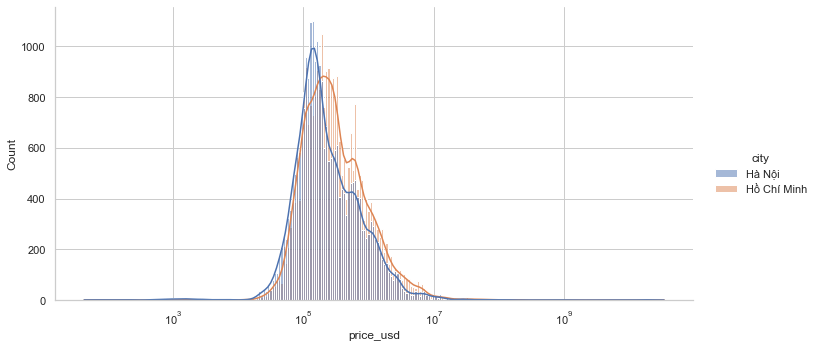

In [11]:
ax = sns.displot(data=data, x='price_usd',  hue='city', log_scale=True, kde=True, aspect=2) #logged

Log(Price) shows rightly skewed distribution, meaning most listings fall below the mean price. There are big estates that are pushing the prices. HCM real estates are more skewed right (more expensive listings with more frequency).

### Prices by District

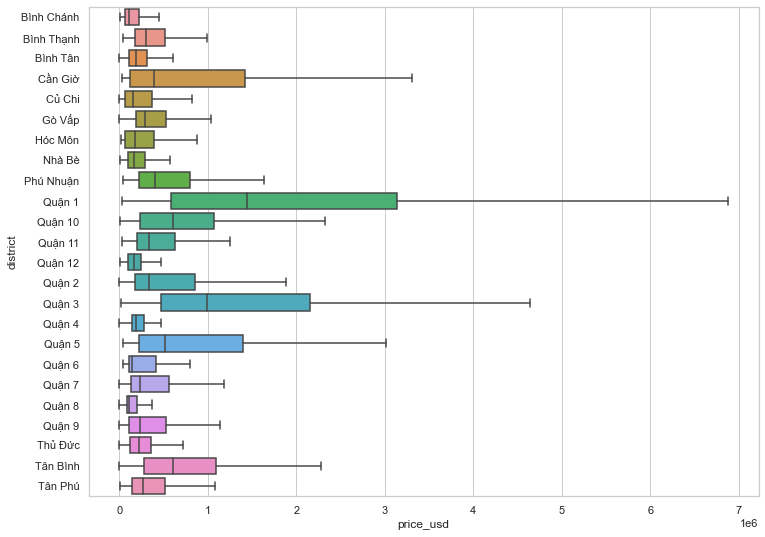

In [12]:
hcm = data[data['city']=='Hồ Chí Minh']

#https://stackoverflow.com/questions/35131798/tweaking-seaborn-boxplot
ax = sns.boxplot(y='district', 
                 x='price_usd',
                 data=hcm, 
                 orient='h',
                 order=sorted(hcm['district'].unique()),
                 showfliers=False)

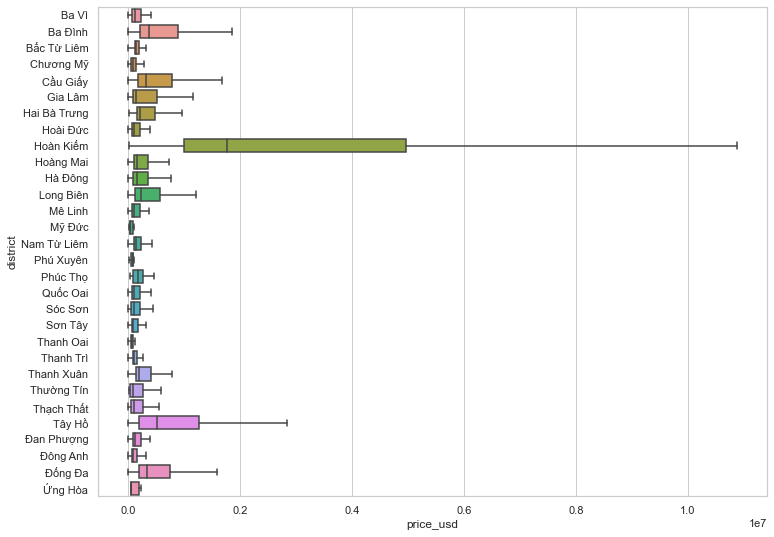

In [13]:
hn = data[data['city']=='Hà Nội']

ax = sns.boxplot(y='district', 
                 x='price_usd',
                 data=hn, 
                 orient='h',
                 order=sorted(hn['district'].unique()),
                 showfliers=False)

### Prices per m2

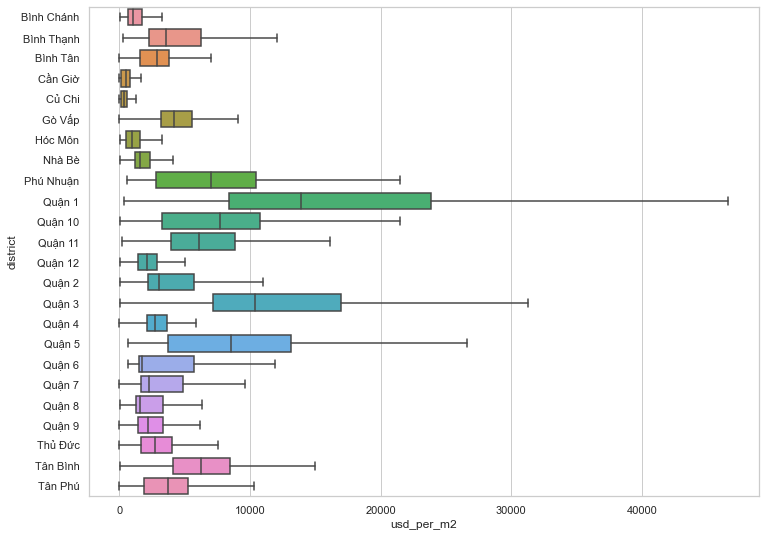

In [14]:
ax = sns.boxplot(y='district', 
                 x='usd_per_m2',
                 data=hcm, 
                 orient='h',
                 order=sorted(hcm['district'].unique()),
                 showfliers=False)

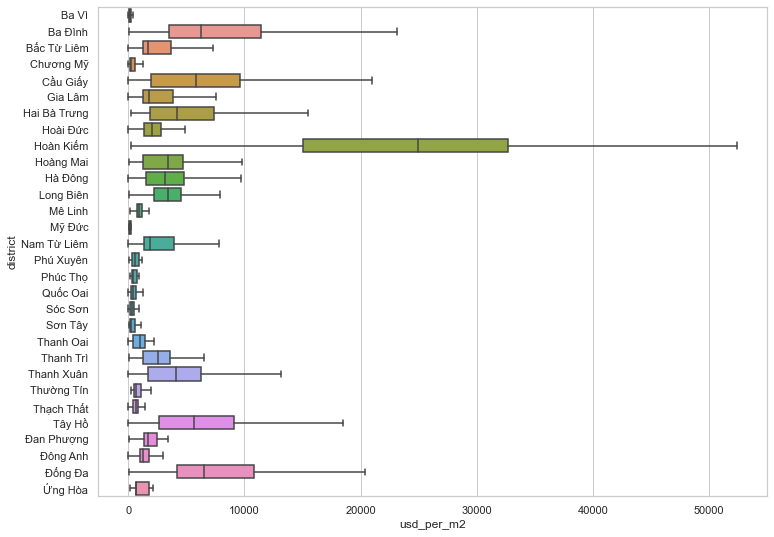

In [15]:
ax = sns.boxplot(y='district', 
                 x='usd_per_m2',
                 data=hn, 
                 orient='h',
                 order=sorted(hn['district'].unique()),
                 showfliers=False)

### Calculate Price Index

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

reg = LinearRegression()

In [17]:
train_df = hcm.dropna()
train_df.describe()

,area_m2,bed,bath,days_since_posted,price_vnd,price_usd,usd_per_m2
count,2298.000000,2298.000000,2298.000000,2298.000000,2.298000e+03,2.298000e+03,2.298000e+03
mean,102.583977,3.356832,3.190165,3.781549,1.334499e+10,5.738345e+05,6.523289e+03
std,281.269451,3.027907,3.166123,3.334386,1.454969e+11,6.256367e+06,9.136432e+04
min,11.000000,1.000000,1.000000,0.000000,1.650000e+06,7.095000e+01,1.108594e+00
25%,59.000000,2.000000,2.000000,1.000000,2.950000e+09,1.268500e+05,1.703552e+03
50%,74.000000,3.000000,2.000000,3.000000,4.990000e+09,2.145700e+05,2.586646e+03
75%,103.000000,4.000000,4.000000,6.000000,7.800000e+09,3.354000e+05,4.333333e+03
max,12500.000000,42.000000,43.000000,23.000000,4.650000e+12,1.999500e+08,3.845192e+06


In [18]:
continuous  = ['area_m2', 'bed', 'bath', 'days_since_posted']
categorical = ['district']

# Get X
# first, get dummies
dummy_df = pd.get_dummies(train_df[categorical], prefix='', prefix_sep='').drop('Quận 12', 1)
# Quận 12 is our baseline dummy
# keeping index is important in merging categorical dummies back
X = pd.concat([train_df[continuous], dummy_df.set_index(train_df.index)], axis=1) 
print(X.shape[0])

# Get y
y = np.log(train_df['price_usd']) #Logged to conform with normal assumption
print(len(y))

2298
2298


In [19]:
# Split 90:10
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [20]:
reg.fit(x_train, y_train)

LinearRegression()

In [21]:
reg.score(x_test, y_test)

0.42268731965999007

Decent accuracy at the moment but could get better with more data.

In [22]:
reg.coef_

array([ 6.91918826e-04,  9.50006028e-03,  9.96880146e-02,  8.69712712e-03,
       -8.33264452e-02,  7.72687755e-01, -1.82684550e-03, -5.61127635e-03,
       -1.61504664e+00,  6.32583019e-01,  1.10008204e-01, -5.42650399e-02,
        7.68258111e-01,  1.12944100e+00,  7.29143540e-01,  1.57757673e-01,
        8.29189922e-01,  1.06616309e+00,  3.46937707e-01,  4.82684430e-01,
        7.19475260e-01,  3.85166707e-01,  1.58797789e-01,  4.26830405e-01,
        5.59061384e-01,  8.76261031e-01,  6.42269554e-01])

#### Just making sure that coefficients from Statsmodel and Sklearn regressions look the same...

In [23]:
import statsmodels.api as sm

X2 = sm.add_constant(x_train)
est = sm.OLS(y_train,X2).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     51.41
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          3.91e-207
Time:                        15:10:02   Log-Likelihood:                -2151.4
No. Observations:                2068   AIC:                             4359.
Df Residuals:                    2040   BIC:                             4517.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.4019      0.072    159.449      0.000      11.262      11.542
area_m2               0.0007   5.61e-05     12.339      0.000       0.001       0.001
bed                   0.0095      0.020      0.481      0.631      -0.029       0.048
bath                  0.0997      0.019      5.272      0.000       0.063       0.137
days_since_posted     0.0087      0.005      1.900      0.058      -0.000       0.018
Bình Chánh           -0.0833      0.111     -0.753      0.451      -0.300       0.134
Bình Thạnh            0.7727      0.088      8.823      0.000       0.601       0.944
Bình Tân             -0.0018      0.096     -0.019      0.985      -0.190       0.187
Cần Giờ              -0.0056      0.693     -0.008      0.994      -1.365       1.354
Củ Chi               -1.6150      0.313     -5.166      0.000      -2.228      -1.002
Gò Vấp                0.6326      0.091      6.915      0.000       0.453       0.812
Hóc Môn               0.1100      0.197      0.557      0.578      -0.277       0.497
Nhà Bè               -0.0543      0.090     -0.602      0.548      -0.231       0.123
Phú Nhuận             0.7683      0.108      7.091      0.000       0.556       0.981
Quận 1                1.1294      0.116      9.768      0.000       0.903       1.356
Quận 10               0.7291      0.118      6.153      0.000       0.497       0.962
Quận 11               0.1578      0.316      0.500      0.617      -0.461       0.777
Quận 2                0.8292      0.077     10.794      0.000       0.679       0.980
Quận 3                1.0662      0.162      6.571      0.000       0.748       1.384
Quận 4                0.3469      0.165      2.105      0.035       0.024       0.670
Quận 5                0.4827      0.149      3.233      0.001       0.190       0.775
Quận 6                0.7195      0.180      3.992      0.000       0.366       1.073
Quận 7                0.3852      0.082      4.671      0.000       0.223       0.547
Quận 8                0.1588      0.099      1.612      0.107      -0.034       0.352
Quận 9                0.4268      0.089      4.795      0.000       0.252       0.601
Thủ Đức               0.5591      0.085      6.615      0.000       0.393       0.725
Tân Bình              0.8763      0.113      7.750      0.000       0.655       1.098
Tân Phú               0.6423      0.103      6.233      0.000       0.440       0.844
==============================================================================
Omnibus:                      681.896   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75340.861
Skew:                           0.506   Prob(JB):                         0.00
Kurtosis:                      32.552   Cond. No.                     1.43e+04
======================

In [24]:
pd.DataFrame(zip(X.columns, reg.coef_, round(est.pvalues, 2), (np.exp(reg.coef_)-1)*100),
             columns=['var', 'log_lin_coef', 'p_value', 'interpretation'])

,var,log_lin_coef,p_value,interpretation
0,area_m2,0.000692,0.00,0.069216
1,bed,0.009500,0.00,0.954533
2,bath,0.099688,0.63,10.482617
3,days_since_posted,0.008697,0.00,0.873506
4,Bình Chánh,-0.083326,0.06,-7.994925
5,Bình Thạnh,0.772688,0.45,116.557899
6,Bình Tân,-0.001827,0.00,-0.182518
7,Cần Giờ,-0.005611,0.98,-0.559556
8,Củ Chi,-1.615047,0.99,-80.111860
9,Gò Vấp,0.632583,0.00,88.246675


With Bình Thạnh as the baseline district, keeping all else equal, a listing in in Quận 10 is about 104% more expensive.

### Post Title and Content

In [25]:
import string

from underthesea import classify, word_tokenize, pos_tag
from collections import defaultdict

Try out Underthesea's classification function (their data comes from Baomoi, so topics still limited):

In [26]:
for i in data['title_raw'][:10]:
    print("{}: {}".format(classify(i), i))

['vi_tinh']:  BT 200 - 400m2 The Phoenix Garden LH: 0918756788
['doi_song']: Chính chủ bán biệt thự Pháp cổ full nội thất KD nhà hàng tại số 8 Hạ Hồi, DT 99m2, giá 27 tỷ
['chinh_tri_xa_hoi']: Nhận đặt chỗ quỹ căn góc đẹp nhất khu C dự án Xanh Villas diện tích từ 200m2 đến hơn 1000m2
['chinh_tri_xa_hoi']: Bán nhà La Phù, gần Lê Trọng Tấn, cách Aeonmall Hà Đông 1km, ô tô cách 30m
['chinh_tri_xa_hoi']: Quỹ căn tháng 4/2021 shophouse, biệt thự, liền kề Vinhomes Ocean Park giá rẻ
['chinh_tri_xa_hoi']: Bán biệt thự sân vườn dãy D03 An Vượng Villas, vị trí đẹp nhất dự án, view hồ, 13 tỷ. 0989 69 59 54
['chinh_tri_xa_hoi']: Bảng hàng shophouse liền kề, biệt thự Louis City Hoàng Mai mặt đường Tân Mai vị trí đẹp giá gốc CĐT
['kinh_doanh']: Bán biệt thự Louis City Hoàng Mai, siêu phẩm cho khách đầu tư
['chinh_tri_xa_hoi']: Tổng hợp các căn hộ cần chuyển nhượng giá gốc Vinhomes Ocean Park. Liên hệ 0962432084
['doi_song']: Tây Hồ Residence ngay Hồ Tây ra bảng hàng tầng cao 4 mặt view Hồ giá từ 3,3 

In [27]:
def clean_text(text):
    """Clean text"""
    #To remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    # will replace newline with space
    text = re.sub('\n',' ',text)
    # will replace numbers with space
    text = re.sub(' [0-9]+ ',' ',text)
    # will convert to lower case
    text = text.lower()
    # will split and join the words
    text = ' '.join(text.split())
    return text

# def get_word_freq(df):
#     """Return dict of word-POS and frequency count"""
#     word_freq = defaultdict(int) #init dict
#     for content in df['content_raw']:
#         try:
#             text = clean_text(content.encode('latin1').decode('utf8')) #special decode
#         except:
#             text = clean_text(content) #some raw contents don't need decodes
#         for word_pos in pos_tag(text):
#             if word_pos[0] not in stopwords_viet:
#                 word_freq[word_pos] += 1
                
def get_word_freq(df):
    """Return dict of words and frequency count"""
    word_freq = defaultdict(int) #init dict
    for content in df['content_raw']:
        try:
            text = clean_text(content.encode('latin1').decode('utf8')) #special decode
        except:
            text = clean_text(content) #some raw contents don't need decodes
        for word in word_tokenize(text):
            if word not in stopwords_viet:
                word_freq[word] += 1
    
    return word_freq

In [28]:
# Get stopwords for Vietnamese from https://xltiengviet.fandom.com/wiki/Danh_s%C3%A1ch_stop_word
stopwords_viet = np.loadtxt('stopwords_viet.txt',delimiter='\n',dtype=str)
stopwords_viet

array(['bị', 'bởi', 'cả', 'các', 'cái', 'cần', 'càng', 'chỉ', 'chiếc',
       'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của',
       'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều',
       'điều', 'do', 'đó', 'được', 'dưới', 'gì', 'khi', 'không', 'là',
       'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một_cách', 'này', 'nên', 'nếu',
       'ngay', 'nhiều', 'như', 'nhưng', 'những', 'nơi', 'nữa', 'phải',
       'qua', 'ra', 'rằng', 'rằng', 'rất', 'rất', 'rồi', 'sau', 'sẽ',
       'so', 'sự', 'tại', 'theo', 'thì', 'trên', 'trước', 'từ', 'từng',
       'và', 'vẫn', 'vào', 'vậy', 'vì', 'việc', 'với', 'vừa'], dtype='<U8')

In [29]:
eg = data.iloc[0, 9] #content_raw
print('Raw example of encoded content:\n{}'.format(eg))
print('Decoded:\n{}'.format(eg.encode('latin1').decode('utf8')))
print('Tokenized by Underthesea:\n{}\n'.format(word_tokenize(eg.encode('latin1').decode('utf8'))))
print('Tokenized by Underthesea with clean text:\n{}'.format(word_tokenize(clean_text(eg.encode('latin1').decode('utf8')))))

Raw example of encoded content:

 - Cam káº¿t giÃ¡ bÃ¡n ráº» nháº¥t thá» trÆ°á»...
                        
Decoded:

 - Cam kết giá bán rẻ nhất thị trườ...
                        
Tokenized by Underthesea:
['Tôi', 'có', 'căn', '200', 'm2', 'cần', 'bán', 'gấp', ',', 'hỗ trợ', 'tất cả', 'thuế', 'phí', 'mua bán', '.', '-', 'Diện tích', 'xây', ':', '100', 'm2', 'thiết kế', '3', 'tầng', '+', '1', 'tum', ',', 'mẫu', 'biệt thự', 'song', 'lập', 'mới', '.', '-', 'C6A', '-', '04', 'diện tích', '200', 'm2', ',', 'mặt tiền', '8', 'm', ',', 'hướng', 'Tây Bắc', ',', 'vị trí', 'đẹp', '.', 'Đất', 'đồi', 'cao', ',', 'gần', 'hồ', 'trung tâm', ',', 'gần', '2', 'cổng', 'chính', 'đường', 'Tây', 'thăng long', '.', '-', 'Hỗ trợ', 'vay', 'vốn', 'ngân hàng', 'tới', '80', '%', ',', 'chiết khấu', '8', '%', 'giá trị', 'xây', 'thô', '.', '-', 'Cam kết', 'giá', 'bán', 'rẻ', 'nhất', 'thị', 'trườ', '...']

Tokenized by Underthesea with clean text:
['tôi', 'có', 'căn', '200', 'm2', 'cần', 'bán', 'gấp', 'hỗ trợ', '

In [30]:
hcm_words = get_word_freq(hcm)
hn_words  = get_word_freq(hn)

print("Top HCM Listing Words:\n{}\nTop HN Listing Content:\n{}\n".format(sorted(hcm_words.items(), key=lambda item: item[1], reverse=True)[:10], 
                                                                         sorted(hn_words.items(), key=lambda item: item[1], reverse=True)[:10]))

Top HCM Listing Words:
[('m', 26127), ('nhà', 25893), ('bán', 25538), ('m2', 21043), ('đường', 17549), ('giá', 17465), ('diện tích', 14591), ('quận', 12610), ('tỷ', 12584), ('đất', 10268)]
Top HN Listing Content:
[('nhà', 29145), ('m2', 27986), ('bán', 24992), ('m', 22946), ('tầng', 16823), ('diện tích', 14745), ('chủ', 12075), ('đất', 11017), ('đường', 10889), ('giá', 10683)]



In [31]:
# hcm_words_df = pd.DataFrame([[k[0]] + [k[1]] + [v] for k, v in hcm_words.items()], 
#                    columns=['word', 'pos', 'freq'])
# hn_words_df = pd.DataFrame([[k[0]] + [k[1]] + [v] for k, v in hn_words.items()], 
#                    columns=['word', 'pos', 'freq'])
hcm_words_df = pd.DataFrame([[k] + [v] for k, v in hcm_words.items()], 
                   columns=['word', 'freq'])
hn_words_df = pd.DataFrame([[k] + [v] for k, v in hn_words.items()], 
                   columns=['word', 'freq'])

# Merge and fill non matching words
freq_df = pd.merge(left=hcm_words_df, 
                   right=hn_words_df, 
                   how='outer', 
#                    on=['word', 'pos'],
                   on=['word'],
                   suffixes=("_hcm", "_hn"),copy=True).fillna(0)

# Get word concentrations
freq_df['concentration_hcm'] = freq_df['freq_hcm']/freq_df['freq_hcm'].sum()
freq_df['concentration_hn']  = freq_df['freq_hn']/freq_df['freq_hn'].sum()
freq_df['diff'] = np.abs(freq_df['concentration_hcm']-freq_df['concentration_hn'])

# Remove some common
exclude = ['m2', '2', 'm', 'bán', 'dt', 'nhà', 'giá', 'đường', 'quận', 'tỷ', 'pn']
freq_df = freq_df[~freq_df['word'].isin(exclude)]

freq_df.sort_values('concentration_hcm', ascending=False)[:20]

,word,freq_hcm,freq_hn,concentration_hcm,concentration_hn,diff
89,diện tích,14591.0,14745.0,0.014083,0.013837,0.000246
36,đất,10268.0,11017.0,0.009911,0.010339,0.000428
8,khu,9555.0,8215.0,0.009223,0.007709,0.001513
65,căn hộ,9357.0,9009.0,0.009032,0.008455,0.000577
143,vị trí,8525.0,8959.0,0.008228,0.008408,0.000179
122,căn,8516.0,9321.0,0.008220,0.008747,0.000528
82,lầu,8291.0,5.0,0.008003,0.000005,0.007998
78,mặt tiền,8230.0,8431.0,0.007944,0.007912,0.000032
77,chủ,8095.0,12075.0,0.007813,0.011332,0.003518
84,đẹp,7493.0,10403.0,0.007232,0.009763,0.002530


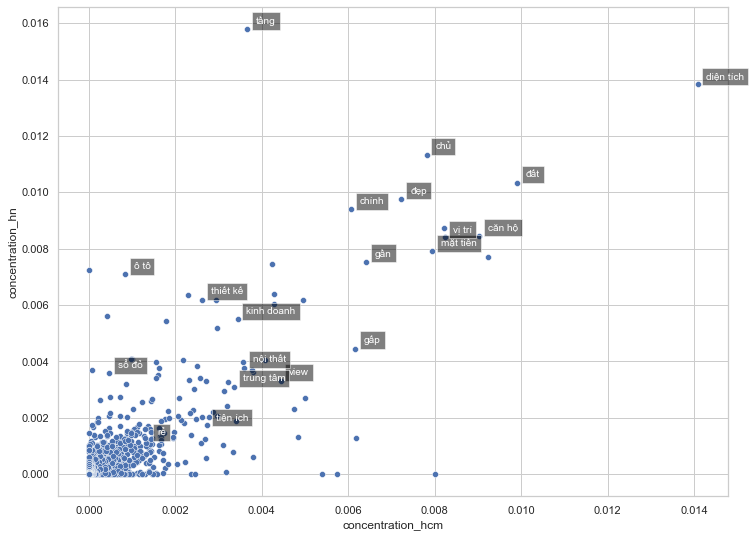

In [33]:
plttext_dict = dict(zip(freq_df['word'], zip(freq_df['concentration_hcm'], freq_df['concentration_hn'])))
plttext= ['thiết kế', 'view', 'mặt tiền', 'kinh doanh', 'tiện ích', 
          'trung tâm', 'ô tô', 'sổ đỏ', 'gấp', 'rẻ', 'nội thất',
          'đất', 'chủ', 'gần', 'vị trí', 'đẹp', 'diện tích', 'tầng',
          'chính', 'căn hộ']

sns.scatterplot(data=freq_df, x='concentration_hcm', y='concentration_hn'
#                 , hue='pos'
               )
for txt in plttext:
    plt.text(x=plttext_dict[txt][0]+0.0002, 
             y=plttext_dict[txt][1]+0.0002, 
             s=txt,
             fontdict=dict(color='white',size=10),
             bbox=dict(facecolor='black',alpha=0.5))

plt.show()

### Daily Prices Time Series

In [39]:
# Connect client to access all items in bucket
client = boto3.client('s3', aws_access_key_id=ACCESS_KEY, aws_secret_access_key=ACCESS_SECRET_KEY)
objs   = client.list_objects(Bucket=BUCKET_NAME)['Contents']

# Read data
col = {'uid':'object', 
       'prid':'object', 
       'url':'object', 
       'title_raw':'object', 
       'price_raw':'object',
       'area_raw':'object',
       'bedroom_raw':'object', 
       'toilet_raw':'object', 
       'location_raw':'object', 
       'content_raw':'object', 
       'post_date':'object',
       'scrape_timestamp':'object'}

date_cols = ['post_date', 'scrape_timestamp']

data = {}
for obj in objs:
    city = obj['Key'].split('-',1)[0]
    date = obj['Key'].split('-',1)[1].split('.')[0]
    if city not in data:
        data[city] = {}
        
    try:
        # read csv and get median
        csv_obj = client.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])
        body = csv_obj['Body'].read().decode('utf-8')
        temp = pd.DataFrame(pd.read_csv(StringIO(body), header=0, sep=',', dtype=col, parse_dates=date_cols))
        
        # process
        temp = temp.drop_duplicates(subset=['uid', 'prid', 'scrape_timestamp'], keep='first')
        temp['district']  = temp.apply(lambda x: x['location_raw'].split(", ")[0], axis=1)
        temp['area_m2']   = temp.apply(lambda x: getArea(x['area_raw']), axis=1)
        temp['price_usd'] = temp.apply(lambda x: convertPrice(x['price_raw'], x['area_raw']), axis=1)*0.000043
        
        # write
        if date not in data[city]: 
            data[city][date] = {}
        else:
            data[city][date]['median'] = temp.groupby(['district'])['price_usd'].median().to_dict()
            data[city][date]['min'] = temp.groupby(['district'])['price_usd'].min().to_dict()
            data[city][date]['max'] = temp.groupby(['district'])['price_usd'].max().to_dict()
            data[city][date]['avg'] = temp.groupby(['district'])['price_usd'].mean().to_dict()
            print("Successfully read {}...".format(obj['Key']))
    except:
        print("Failed to read {}...".format(obj['Key']))

In [41]:
data

{'hanoi': {'04-15-2021': {},
  '04-16-2021': {},
  '04-17-2021': {},
  '04-18-2021': {},
  '04-19-2021': {},
  '04-20-2021': {},
  '04-21-2021': {},
  '04-23-2021': {}},
 'hcm': {'04-15-2021': {},
  '04-16-2021': {},
  '04-17-2021': {},
  '04-18-2021': {},
  '04-19-2021': {},
  '04-20-2021': {},
  '04-21-2021': {},
  '04-23-2021': {}}}

In [ ]:
cities    = []
dates     = []
districts = []
medians   = []

for city, v1 in data.items():
    for date, v2 in v1.items():
        for district, v3 in v2.items():
            cities.append(city)
            dates.append(date)
            districts.append(district)
            medians.append(v3)
            
ts_df = pd.DataFrame({'city':cities, 'date':dates, 'district':districts, 'median':medians})
ts_df.head()

In [ ]:
sns.lineplot(data=ts_df, x="date", y="median", hue="district")